In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import bernoulli
from collections import defaultdict
from tensorflow.keras import initializers, optimizers, layers, activations, Model, losses, metrics, callbacks
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
data_NU = pd.read_csv('../datasets/cleavage_NU.csv.gz') \
            .rename(columns={'junction': 'rna'}) \
            .query('sub_mod == "U" or sub_mod == "psi"') \
            .drop(['pos', 'total_reads'], axis=1)

In [5]:
data_NC = pd.read_csv('../datasets/cleavage_NC.csv.gz')
data_NC = data_NC.groupby(['core', 'sub_mod', 'rna']).agg({'FC': np.mean}).reset_index()

In [6]:
data = pd.concat([data_NC, data_NU]).sample(frac=1)
print('Number of records: %d' % data_NU.shape[0])

Number of records: 34698


In [7]:
data_test = data.sample(frac=0.1)
data_train = data.drop(data_test.index)
data_val = data_train.sample(frac=0.2)
data_train = data_train.drop(data_val.index)
print('Train size: %d, Val size %d, Test size %d' % (data_train.shape[0], data_val.shape[0], data_test.shape[0]))

Train size: 139275, Val size 37033, Test size 21272


In [8]:
def one_hot_core(seqs, letters='ACGT'):
    enc = defaultdict(lambda: np.array([0.25] * len(letters)))
    seqs_oh = []
    for i, letter in enumerate(letters):
        f = np.zeros(len(letters), dtype=np.int32)
        f[i] = 1
        enc[letter] = f
    for seq in seqs:
        one_hot_features = []
        for c in seq:
            one_hot_features.append(np.array(enc[c]))
        seqs_oh.append(np.stack(one_hot_features).T)
    return np.stack(seqs_oh).astype(np.float32)

def one_hot_rna(rnas):
    enc = {'AC': [1, 0, 0, 0, 0, 0, 0, 0],
           'CC': [0, 1, 0, 0, 0, 0, 0, 0],
           'GC': [0, 0, 1, 0, 0, 0, 0, 0],
           'UC': [0, 0, 0, 1, 0, 0, 0, 0],
           'AU': [0, 0, 0, 0, 1, 0, 0, 0],
           'CU': [0, 0, 0, 0, 0, 1, 0, 0],
           'GU': [0, 0, 0, 0, 0, 0, 1, 0],
           'UU': [0, 0, 0, 0, 0, 0, 0, 1]}
    rnas_oh = []
    for rna in rnas:
        rnas_oh.append(enc[rna])

    return np.stack(rnas_oh).astype(np.float32)

def one_hot_mod(mods):
    enc = {'C':   [1, 0, 0, 0, 0, 0],
           'm3C': [0, 1, 0, 0, 0, 0],
           'm4C': [0, 0, 1, 0, 0, 0],
           'm5C': [0, 0, 0, 1, 0, 0],
           'U':   [0, 0, 0, 0, 1, 0],
           'psi': [0, 0, 0, 0, 0, 1]}
    mods_oh = []
    for mod in mods:
        mods_oh.append(enc[mod])
    return np.stack(mods_oh).astype(np.float32)

def pad(seq, seq_len):
    left_fillchars = list('GACTAGTTAC')
    right_fillchars = list('TTCATTCAGT')
    result = list(seq)
    while len(result) < seq_len:
        if bernoulli.rvs(0.5):
            result.insert(0, left_fillchars.pop())
        else:
            result.append(right_fillchars.pop(0))
    return ''.join(result)

def prepare_data(data, seq_len, threshold, batch_size):
    core = one_hot_core(data['core'].apply(lambda x: pad(x, seq_len)))[..., np.newaxis]
    rna = one_hot_rna(data['rna'].values)
    mod = one_hot_mod(data['sub_mod'].values)
    label = data['FC'].apply(lambda x: 0 if x < threshold else 1).values.astype(np.int32)
    class_weight = {0: 1 / (np.sum(label == 0) / label.size) / 2,
                    1: 1 / (np.sum(label == 1) / label.size) / 2}
    bias = np.log(np.sum(label == 1) / np.sum(label == 0))
    ds = tf.data.Dataset.from_tensor_slices(({'input_core': core, 'input_rna': rna, 'input_mod': mod}, label)).batch(batch_size)

    return ds, class_weight, bias

In [9]:
SEQ_LENGTH = 24
MOTIFS = 32
MOTIF_LEN = 20
THRESHOLD = 0.2
BATCH_SIZE = 64

train_ds, class_weight, bias = prepare_data(data_train, SEQ_LENGTH, THRESHOLD, BATCH_SIZE)
val_ds, _, _ = prepare_data(data_val, SEQ_LENGTH, THRESHOLD, BATCH_SIZE)

In [10]:
print(f'class weights: 1: {class_weight[1]}, 0: {class_weight[0]} \nbias: {bias}')

class weights: 1: 4.695084951456311, 0: 0.5595935488536921 
bias: -2.127060770919201


In [11]:
def get_model(seq_len, motifs, motif_len, bias):
    input_core = layers.Input(shape=(4, seq_len, 1), name='input_core')
    input_rna = layers.Input(shape=(8,), name='input_rna')
    input_mod = layers.Input(shape=(6,), name='input_mod')

    #motif_features
    x = layers.Conv2D(filters=motifs,
                    kernel_size=(4, motif_len),
                    activation=activations.exponential, name='motif_scanner')(input_core)
    x = layers.GlobalMaxPooling2D()(x)

    conc = layers.Concatenate()([x, input_rna, input_mod])
    conc = layers.Dense(64, activation='relu')(conc)
    outputs = layers.Dense(1, activation='sigmoid',
                           bias_initializer=initializers.Constant(bias))(conc)

    return Model([input_core, input_rna, input_mod], outputs)

In [12]:
model = get_model(SEQ_LENGTH, MOTIFS, MOTIF_LEN, bias=bias)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_core (InputLayer)         [(None, 4, 24, 1)]   0                                            
__________________________________________________________________________________________________
motif_scanner (Conv2D)          (None, 1, 5, 32)     2592        input_core[0][0]                 
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 32)           0           motif_scanner[0][0]              
__________________________________________________________________________________________________
input_rna (InputLayer)          [(None, 8)]          0                                            
______________________________________________________________________________________________

In [14]:
model.compile(optimizer=optimizers.Adam(learning_rate=5e-4),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.AUC(name='roc'),
                       metrics.AUC(curve='PR', name='pr')])

In [15]:
np.mean(model(next(train_ds.as_numpy_iterator())[0]))

0.06979786

In [16]:
history = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=0,
                    class_weight=class_weight,
                    callbacks=[callbacks.ReduceLROnPlateau(),
                               callbacks.EarlyStopping(patience=20), 
                               tf.keras.callbacks.ModelCheckpoint(f'./models/deepbind_{THRESHOLD}.keras',
                                                                  monitor='val_pr',
                                                                  save_best_only=True)])

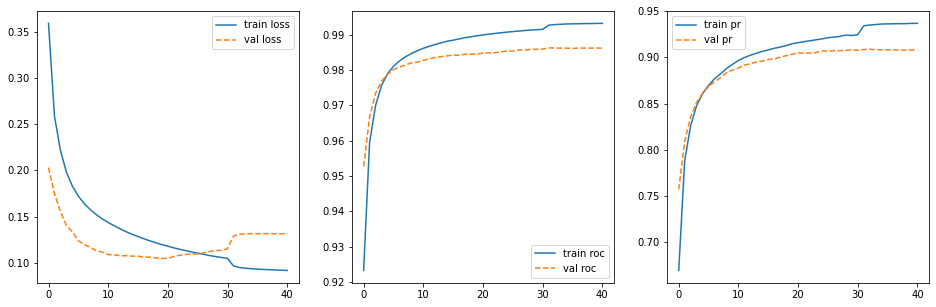

In [17]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], linestyle='--', label='val loss')
plt.legend()

plt.subplot(132)
plt.plot(history.history['roc'], label='train roc')
plt.plot(history.history['val_roc'], linestyle='--', label='val roc')
plt.legend()

plt.subplot(133)
plt.plot(history.history['pr'], label='train pr')
plt.plot(history.history['val_pr'], linestyle='--', label='val pr')
plt.legend()

In [18]:
test_ds, _, _ = prepare_data(data_val, SEQ_LENGTH, THRESHOLD, BATCH_SIZE)

In [19]:
y_pred = model.predict(test_ds)
y_true = np.concatenate([label for features, label in test_ds], axis=0)

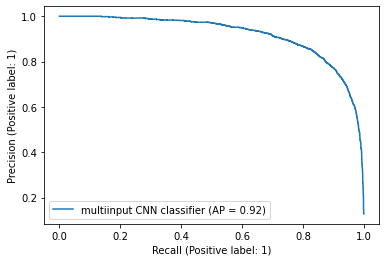

In [20]:
PrecisionRecallDisplay.from_predictions(y_true, y_pred, name='multiinput CNN classifier')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     33183
           1       0.85      0.83      0.84      3850

    accuracy                           0.97     37033
   macro avg       0.92      0.91      0.91     37033
weighted avg       0.97      0.97      0.97     37033



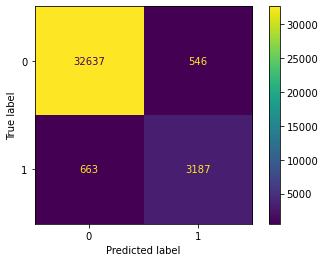

In [21]:
CLF_THRESHOLD = 0.9
print(classification_report(y_true, y_pred > CLF_THRESHOLD))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred > CLF_THRESHOLD);